# CfL in Action

Although The YCbCr/YUV color spaces are designed to eliminate correlation between color planes. Local correlation between color planes can exist. Chroma from Luma (CfL) exploits this correlation by predicting chroma pixels using reconstructed luma pixel values.

In this notebook, we will demonstrate in a visual way how CfL works. To do so, we will convert an image from RGB to YCbCr and using the luma values show all possible predictions that can be acheived using barrbrain's simple 1D notebook.

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 $('#toggle').attr('value', 'Show code')  
 } else {
 $('div.input').show();
 $('#toggle').attr('value', 'Hide code') 
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggle" value="Show code"></form>''')

In [2]:
%matplotlib inline

from scipy.ndimage  import imread
import matplotlib.pyplot as plt
import numpy as np
import locale

def conv_ycbcr(im):
    y = np.array([0.213, 0.715, 0.072])
    u = np.array([-0.115, -0.385, 0.5])
    v = np.array([0.5, -0.454, -0.046])
    color_matrix = np.array([y, u, v])
    yuv = im.dot(color_matrix.T)
    yuv[:,:,[1,2]] += 128
    
    return yuv

def conv_rgb(im):
    im[:,:,[1,2]] -= 128
    
    r = np.array([1, 0, 1.575])
    g = np.array([1, -0.187, -0.468])
    b = np.array([1, 1.856, 0])
    color_matrix = np.array([r,g,b])
    
    rgb = im.dot(color_matrix.T)
    rgb[rgb < 0] = 0
    rgb[rgb > 255] = 255
    rgb = np.uint8(rgb)
    
    return rgb

In AV1, CfL is applied to intra prediction blocks. For this example, we will find a block with highly correlated luma and chroma planes.

0.012901969871624647
0.10939051022721716
0.13274453812503847
0.19582986978906758
0.41670772833730085
0.4721853155714943
0.5084059492208742
0.5310124398606134
128
80


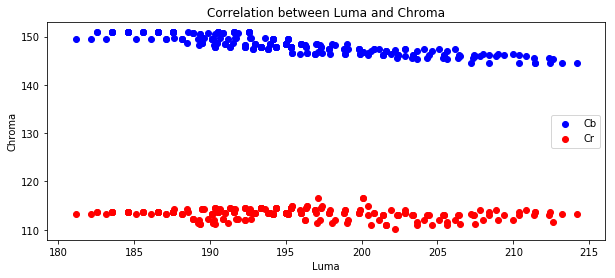

In [95]:
np.seterr(divide='ignore', invalid='ignore')
im = plt.imread("../images/SnowbirdTram.jpg")
yuv = conv_ycbcr(im)
height, width, planes = im.shape
block_size = 16
height = height // block_size * block_size
width = width // block_size * block_size
max_Corr = 0
for y in range(0, height, block_size):
    for x in range(0, width, block_size):
        block = yuv[y:y+block_size, x:x+block_size, :]
        corr = (np.corrcoef(block[:,:,0].flatten(), block[:,:,1].flatten()) + np.corrcoef(block[:,:,0].flatten(), block[:,:,2].flatten()))/2
        corr = abs(corr[0,1])
        if corr > max_Corr and corr < 0.6:
            print(corr)
            max_Corr = corr
            best_x = x
            best_y = y


im = im[best_y:best_y+block_size, best_x:best_x+block_size,:]
yuv = yuv[best_y:best_y+block_size, best_x:best_x+block_size,:]
print(best_x)
print(best_y)

plt.figure(figsize=(10,4))
#plt.subplot(1,2,1)
#plt.imshow(im)
#plt.title("Size: %d x %d" % (block_size, block_size))
#plt.axis('off');

#plt.subplot(1,2,2)
plt.scatter(yuv[:,:,0], yuv[:,:,1], label='Cb', color="b")
plt.scatter(yuv[:,:,0], yuv[:,:,2], label='Cr', color="r")
plt.legend(['Cb', 'Cr'])
plt.title("Correlation between Luma and Chroma")
plt.xlabel("Luma")
plt.ylabel("Chroma");

In [84]:
round((height/block_size * width/block_size))

210

The prediction built by CfL is based on the reconstructed Luma pixels. In this example, we will use the original Luma pixels as the reconstructed Luma pixel

In the AV1 version of CfL, the Chroma block is first predicted using the average pixel values of the neighboring pixels above and to the left of the block. For this example, we predict the chromatic planes using the average value of each plane.

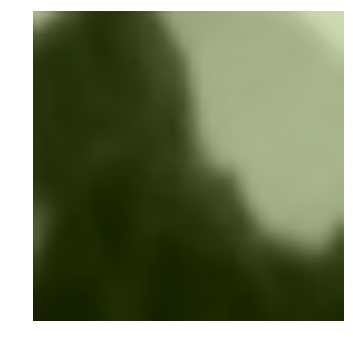

In [4]:
pred_u = yuv[:,:,1].mean()
pred_v = yuv[:,:,2].mean()

luma = yuv[:,:,0]
u = np.ones((block_size, block_size)) * pred_u
v = np.ones((block_size, block_size)) * pred_v

def error(im1, im2):
    diff = im1 - im2
    return np.round(np.sum(np.multiply(diff,diff)))

pred_rgb = conv_rgb(np.dstack([luma, u, v]))

plt.figure(figsize=(5,4))
plt.imshow(pred_rgb)
#plt.title("Prediction\n(Luma + Average Chroma Value)")
plt.axis('off');

Next, we show all possible predictions CfL can make, using barrbrain's simple 1D code book. For each prediction, we measure the squared error and pick the best one.

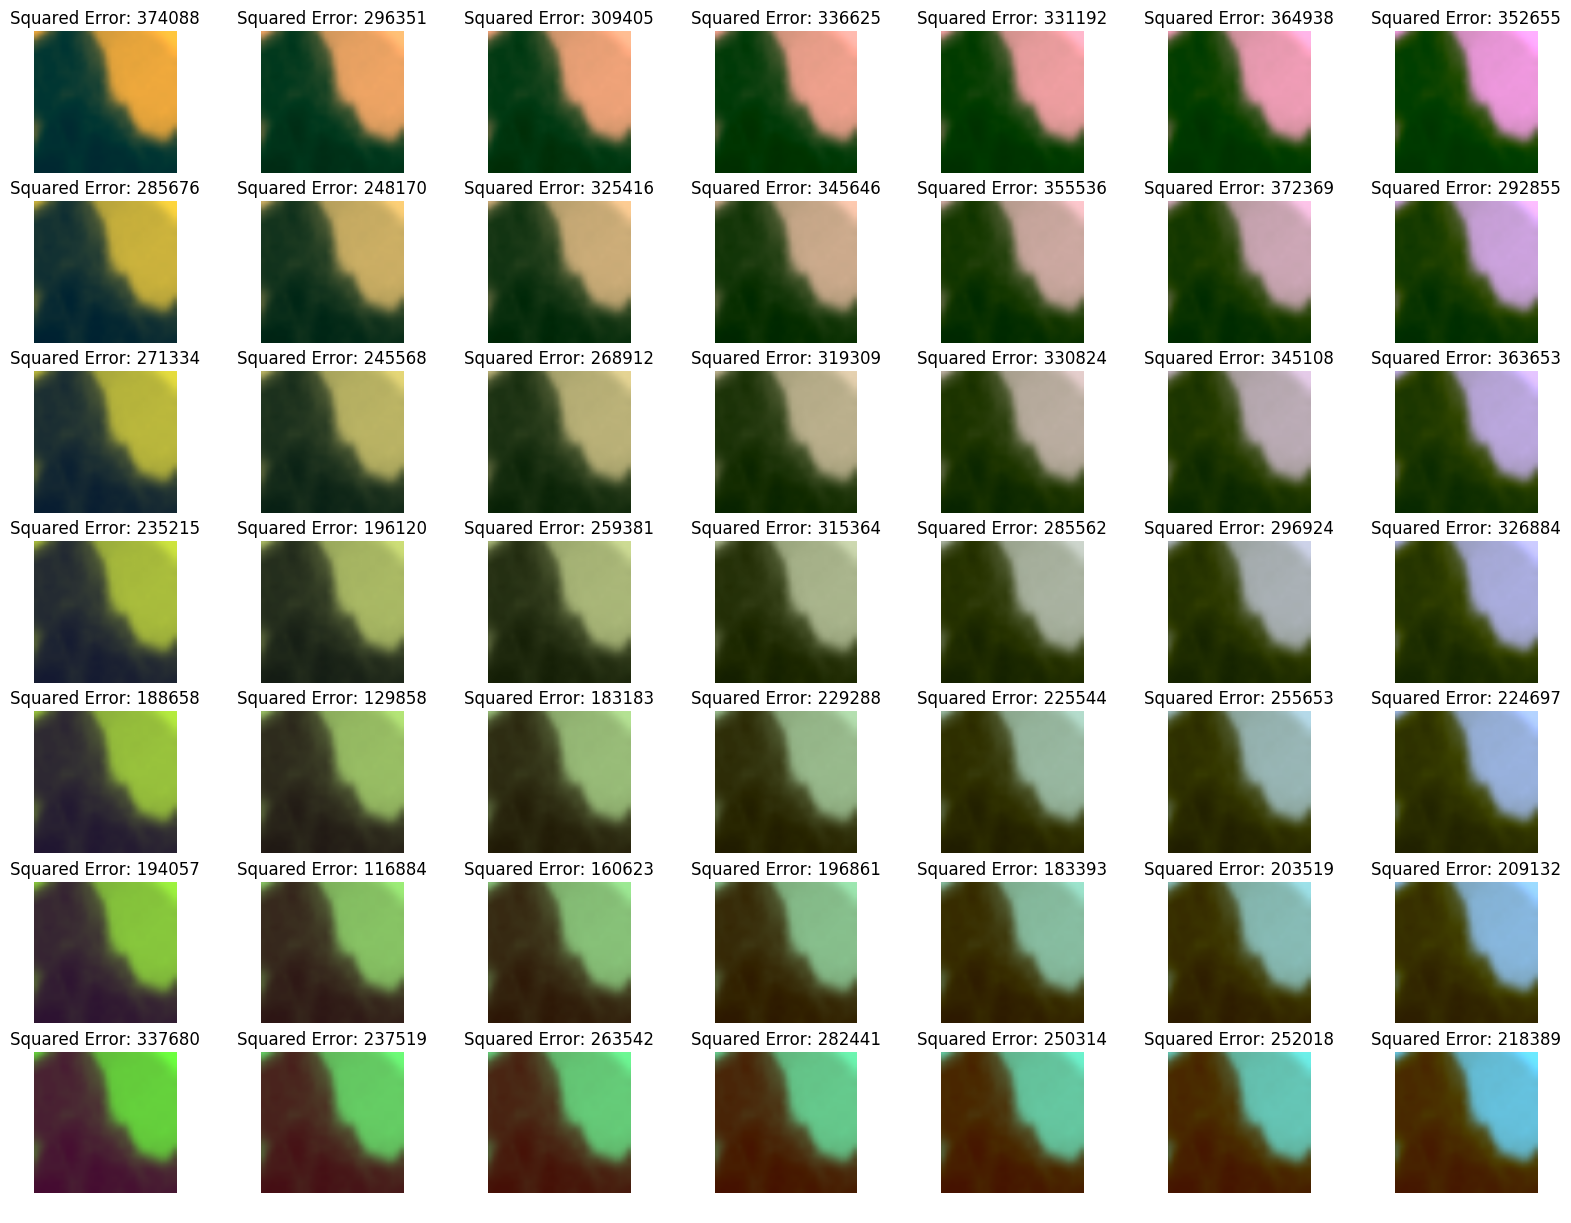

In [5]:
mags = [-.5, -.25, -.125, 0, .125, .25, .5]
M = len(mags)

ycbcr = conv_ycbcr(im)

zm_luma = yuv[:,:,0] - yuv[:,:,0].mean()

plt.figure(figsize=(20,15))

min_Err = 1000000

for x, alpha_cb in enumerate(mags):
    for y, alpha_cr in enumerate(mags):
        alpha_cr = -alpha_cr
        u = pred_u + zm_luma * alpha_cb
        v = pred_v + zm_luma * alpha_cr
        
        rgb = np.uint8(conv_rgb(np.dstack([luma, u, v])))
        plt.subplot(M, M, y * M + x + 1)


        
        err = error(im, rgb)
        if err < min_Err:
            min_Err = err
            best_a_cb = alpha_cb
            best_a_cr = alpha_cr
            
        plt.imshow(np.uint8(rgb))
        plt.title("Squared Error: %d" % err)
        plt.axis('off')

Since a correlation exists between the chromatic planes and the luma plane, we can see that CfL produces a considerably better prediction.

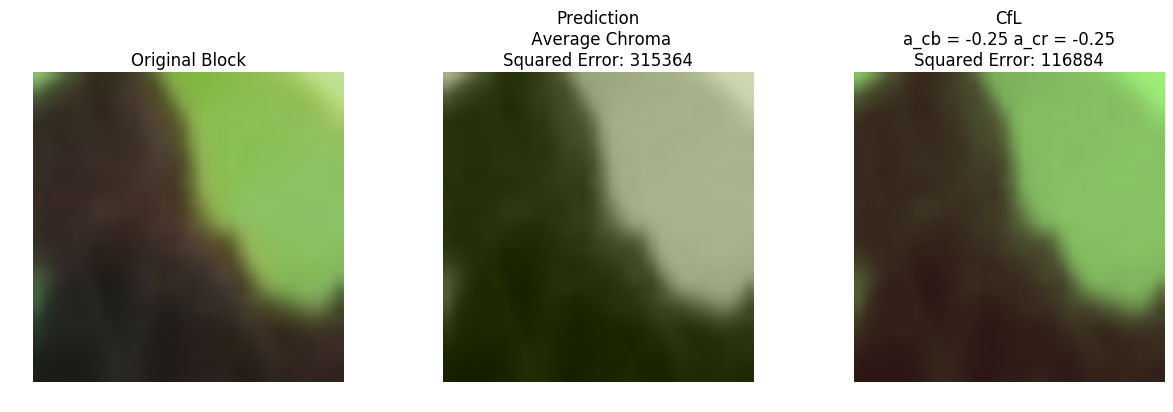

In [6]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.imshow(im)
plt.title("Original Block")
plt.axis('off');

plt.subplot(1,3,2)
plt.imshow(pred_rgb)
plt.title("Prediction\n Average Chroma\nSquared Error: %d" % error(im, pred_rgb))
plt.axis('off');

plt.subplot(1,3,3)
u = pred_u + zm_luma * best_a_cb
v = pred_v + zm_luma * best_a_cr
rgb = conv_rgb(np.dstack([luma, u, v]))
plt.imshow(np.uint8(rgb))
plt.title("CfL\na_cb = %0.2f a_cr = %0.2f\nSquared Error: %d" % (best_a_cb, best_a_cr,min_Err))
plt.axis('off');